# how to generate maze

This notebook explains how to generate a random maze.

We explain an algorithm to generate a maze with rough boundaries so that it becomes challenging to navigate the maze with a controllable avatar.
This kind of random maze is usaful for some research projects related to input and output for remote vehicle control.

## what kind of maze?

This algorithm makes a mazing satstifying the following conditions
- single path
- enterance and exit exists
- the width of the path should be larger than a certain threshold

## concept

(explain concept here)

In [9]:
num_coarse_cells_row = 10
num_coarse_cells_col = 10

# the percentage of coarse path cells in the maze
path_percentage = 0.3

# per coarse cell
num_fine_cells_row = 10
num_fine_cells_col = 10


In [51]:
import numpy as np
import random

def create_coarse_maze():
    coarse_maze = create_random_coarse_maze()
    cell_percentage = calculate_cell_percentage(coarse_maze)
    while cell_percentage < path_percentage:
        coarse_maze = create_random_coarse_maze()
        cell_percentage = calculate_cell_percentage(coarse_maze)

    return coarse_maze

def calculate_cell_percentage(maze: np.ndarray) -> float:
    return np.mean(1 - maze)

def create_random_coarse_maze():
    coarse_maze = np.ones((num_coarse_cells_row, num_coarse_cells_col), dtype=np.uint8)

    # randomly pick the entry
    entry_row = np.random.randint(1, num_coarse_cells_row - 1)
    entry_col = 0

    coarse_maze[entry_row, entry_col] = 0
    cursor = (entry_row, entry_col)

    while True:
        next_cell = select_next_random_cell(coarse_maze, cursor[0], cursor[1])
        if (next_cell):
            coarse_maze[next_cell[0], next_cell[1]] = 0
            cursor = next_cell
            
            if is_on_the_map_boundary(coarse_maze, cursor[0], cursor[1]):
                # cursor is on the edge of the map
                # this will be the exit point
                break
        else:
            break

    return coarse_maze

def select_next_random_cell(maze: np.ndarray, current_row: int, current_col: int) -> (int, int):
    """Select a random cell that is not visited, not adjacent to the visited cells, and not at the boundary """
    n_maze_row = maze.shape[0]
    n_maze_col = maze.shape[1]
    
    valid_next_cells:list[(int, int)] = []

    def is_cell_valid(row: int, col: int) -> bool:
        return is_in_the_map(maze, row, col) and is_not_visited(maze, row, col) and is_not_adjacent_to_visited(maze, current_row, current_col, row, col)

    # check 4 adjacent cells
    if is_cell_valid(current_row - 1, current_col):
        valid_next_cells.append((current_row - 1, current_col))

    if is_cell_valid(current_row + 1, current_col):
        valid_next_cells.append((current_row + 1, current_col))

    if is_cell_valid(current_row, current_col + 1):
        valid_next_cells.append((current_row, current_col + 1))

    if is_cell_valid(current_row, current_col - 1):
        valid_next_cells.append((current_row, current_col - 1))

    if len(valid_next_cells) == 0:
        return None
    
    return random.choice(valid_next_cells)

def is_in_the_map(maze: np.ndarray, row: int, col: int) -> bool:
    n_maze_row = maze.shape[0]
    n_maze_col = maze.shape[1]
    return 0 <= row < n_maze_row and 0 <= col < n_maze_col

def is_on_the_map_boundary(maze: np.ndarray, row: int, col: int) -> bool:
    n_maze_row = maze.shape[0]
    n_maze_col = maze.shape[1]
    return 0 == row or row == n_maze_row - 1 or 0 == col or col == n_maze_col - 1

def is_not_visited(maze: np.ndarray, row: int, col: int) -> bool:
    return maze[row, col] == 1

def is_not_adjacent_to_visited(maze: np.ndarray, current_row: int, current_col: int, next_row: int, next_col: int) -> bool:
    if not is_in_the_map(maze, next_row, next_col):
        return False

    adjacent_cells_except_current = []
    for cell in [(next_row-1, next_col), (next_row+1, next_col), (next_row, next_col+1), (next_row, next_col-1)]:
        if not is_in_the_map(maze, cell[0], cell[1]):
            continue

        if cell != (current_row, current_col):
            adjacent_cells_except_current.append(cell)

    for cell in adjacent_cells_except_current:
        if (maze[cell[0], cell[1]] == 0):
            return False

    return True

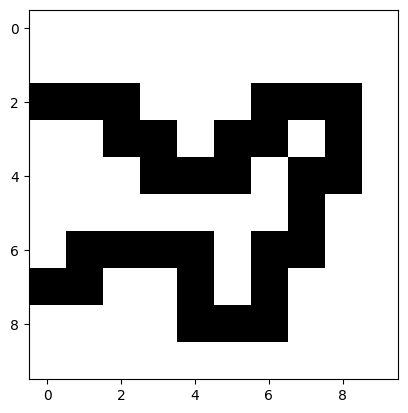

In [54]:
import numpy as np
from matplotlib import pyplot as plt

coarse_maze = create_coarse_maze()

plt.imshow(coarse_maze, cmap='gray')


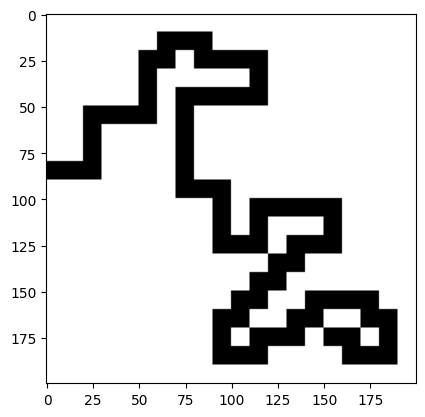

In [47]:
sub_cell = np.ones((num_fine_cells_row, num_fine_cells_col), dtype=np.uint8)

# Kronecker multiplication
maze = np.kron(coarse_maze, sub_cell)

plt.imshow(maze, cmap='gray')